# ECSE415 - Into to Computer Vision
## Assignment 3
### Alexander Harris - 260688155

## 2 - Stereo Vision
### 2.1 - Depth Estimation from Stereo Images

In [28]:
import cv2
import numpy as np
import sys
import re
import math
import time
from struct import *
from matplotlib import pyplot as plt

def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img.astype(np.uint8)

In [25]:
def plotFigures(images):
    """
    Plots images from list in grid.
    
    images: list of images
    title: title for each subplot
    params: specific arguments to add to title
    """
    grid_len = math.ceil(math.sqrt(len(images)))
    
    plt.figure(figsize=(30, 30))
    for i, image in enumerate(images):
        plt.subplot(grid_len, grid_len, i+1), plt.imshow(image['image'], 'gray')
        plt.title('{} - Error: {} - {}'.format(image['title'], image['error'], image['params'])), plt.axis('off')
    plt.show()

In [34]:
# Import left and right images
imgL = cv2.imread('./im0.png', 0)
imgR = cv2.imread('./im1.png', 0)

imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# Import corresponding depth maps
depth_imgL = read_pfm('./disp0.pfm')
depth_imgR = read_pfm('./disp1.pfm')

depth_imgL[depth_imgL == np.inf] = 0
depth_imgR[depth_imgR == np.inf] = 0

depth_imgL = cv2.resize(depth_imgL, None, fx=0.3, fy=0.3)
depth_imgR = cv2.resize(depth_imgR, None, fx=0.3, fy=0.3)

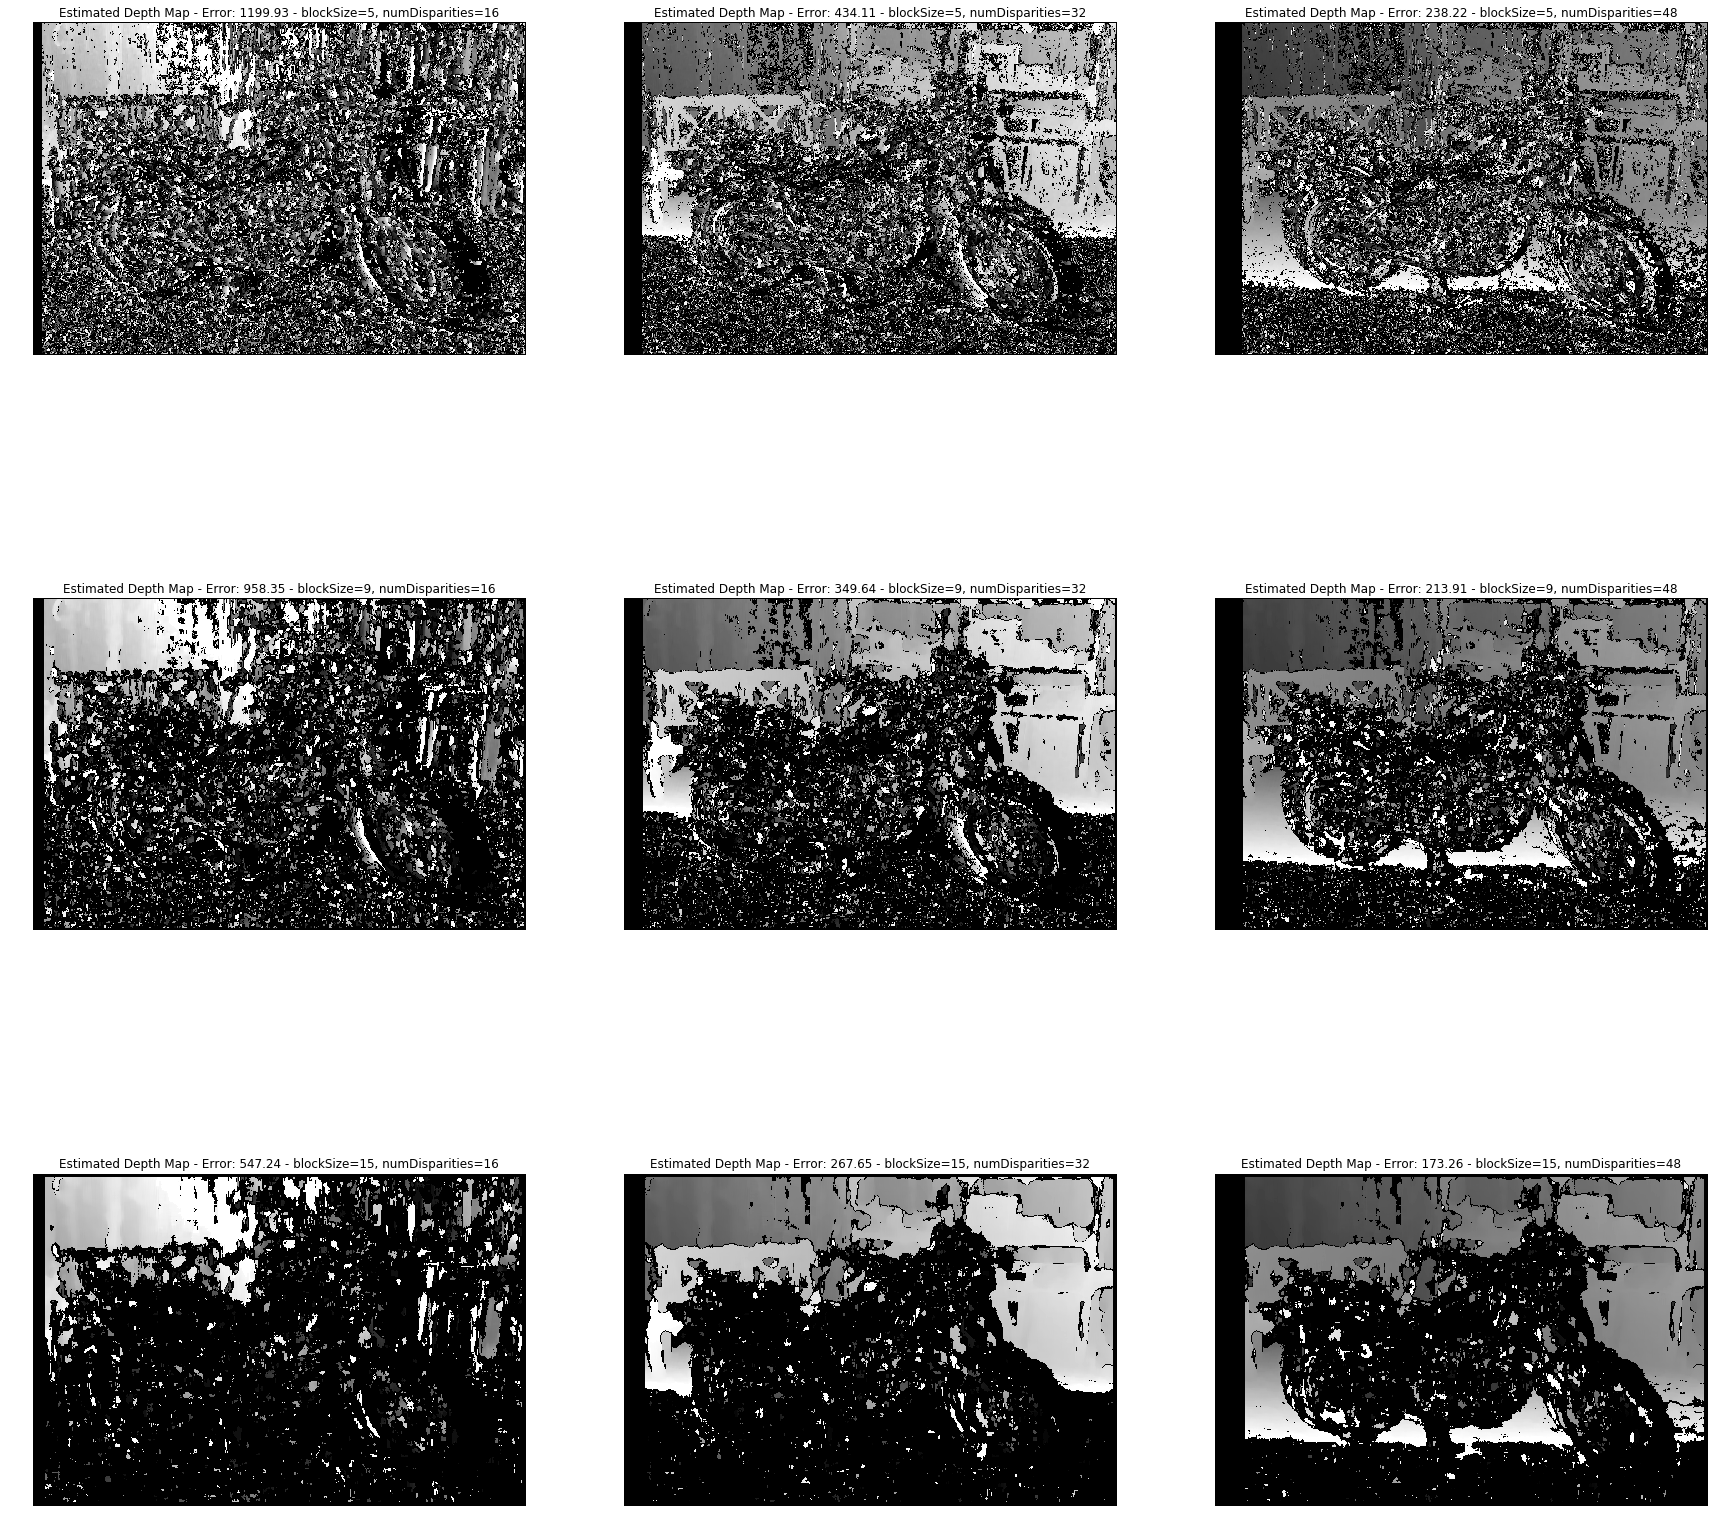

In [31]:
# Sample params
block_size = [5, 9, 15]
num_disp = [16, 32, 48]

images = []

# Create depth map object
stereo = cv2.StereoBM_create()

# Loop through all test params
for size in block_size:
    for disp in num_disp:
        # Set params
        stereo.setNumDisparities(disp)
        stereo.setBlockSize(size)
        
        # Compute experimental and true depth maps
        depth = stereo.compute(imgL, imgR)
        ground = stereo.compute(depth_imgL, depth_imgR)
        
        # Compute square diff. between experimental and true maps
        sq_diff = (ground - depth) ** 2
        summ = np.sum(sq_diff)
        pixels = depth.shape[0] * depth.shape[1]
        error = round(summ / pixels, 2)
        
        res = {'image': depth, 'true': ground, 'title': 'Estimated Depth Map', 'error': error, 'params': 'blockSize={}, numDisparities={}'.format(size, disp)}
        images.append(res)
        
plotFigures(images)

Increasing both parameters appears to reduce noise in the resulting depth map, and by consequence reduce the total error between that experimental and true depth maps. 

Specifically, smaller block sizes result in a more detailed/accurate depth map but also increases the noisiness of the final result, while larger give a smoother disparity map, but obviously less accurate as a consequence. Increasing the number of disparities seems to result in more defined edges in the final disparity map.
